In [1]:
import os
import pathlib
import time
import sys

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image

2023-05-10 03:03:27.955251: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 03:03:28.201750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 03:03:29.978395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/envs/cs109b/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until

In [2]:
print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")
tf.config.run_functions_eagerly(True)

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
# keras.mixed_precision.set_global_policy("mixed_float16")

2023-05-10 03:03:32.799072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 03:03:32.862362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 03:03:32.862642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

tensorflow version 2.12.0
keras version 2.12.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



### Model Structures

In [3]:
class Padded_MSE(keras.losses.Loss):
    """Customed loss function. Use this for training SRCNN networks."""
    def __init__(self, pred_shape, true_shape, crop_pred=False, reduction=keras.losses.Reduction.AUTO, name="pad_mse"):
        super().__init__(name=name, reduction=reduction)
        self.offset = (true_shape - pred_shape) // 2
        self.size = pred_shape
        self.crop_pred = crop_pred

    def call(self, y_true, y_pred):
        y_true=y_true[:, self.offset:self.offset+self.size, self.offset:self.offset+self.size,:]
        if self.crop_pred:
            y_pred = y_pred[:, self.offset:self.offset+self.size, self.offset:self.offset+self.size,:]
        return tf.reduce_mean(tf.math.reduce_mean(tf.math.square(y_pred - y_true), axis=[1,2,3]), axis=0)
#         return tf.reduce_mean(tf.math.square(y_pred - y_true[:, self.offset:self.offset+self.size, self.offset:self.offset+self.size,:]), axis=-1)
    

class PSNR(keras.metrics.Metric):
    """Customed metric. Compute the PSNR of the reconstructed image"""
    def __init__(self, pred_size=None, true_size=None, crop_pred=False, name='psnr', **kwargs):
        super(PSNR, self).__init__(name=name, **kwargs)
        self.psnr = 0
        self.size = pred_size
        if true_size:
            self.offset = (true_size - pred_size) // 2
            self.crop_pred = crop_pred
        self.count = 0
        self.MEAN = tf.constant([0.4488, 0.4271, 0.4040])*255

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.size:
            y_true = y_true[:, self.offset:self.offset+self.size, self.offset:self.offset+self.size, :]
            if self.crop_pred: 
                y_pred = y_pred[:, self.offset:self.offset+self.size, self.offset:self.offset+self.size, :]
  
        y_true = y_true * 127.5 + self.MEAN
        y_pred = y_pred * 127.5 + self.MEAN
        mse = tf.math.sqrt(tf.reduce_mean(tf.math.square(y_pred - y_true), axis=[1,2,3]))
        ps = tf.math.reduce_max(y_true, axis=[1,2,3])
        self.psnr += tf.math.reduce_sum(8.6858 * tf.math.log(ps / mse), axis=-1)
        self.count += y_true.shape[0]
    
    def reset_state(self):
        self.psnr = 0
        self.count = 0

    def result(self):
        return self.psnr / self.count
    
    @classmethod
    def from_config(cls, config, custom_onject=None):
        return cls(**config)
        


In [4]:
def SRCNN(kernel=(9,5,5), mode='large'):
    inp = keras.layers.Input((None, None, 3))
    x = keras.layers.UpSampling2D(size=(4,4), data_format='channels_last', interpolation='bicubic')(inp)
    x = keras.layers.Conv2D(128, kernel_size=kernel[0], strides=1, activation='relu')(x)
    x = keras.layers.Conv2D(64, kernel_size=kernel[1], strides=1,activation='relu')(x)
    out = keras.layers.Conv2D(3, kernel_size=kernel[2], strides=1, activation=None)(x)
    return keras.Model(inp, out)

def compile_srcnn(m: keras.Model, opt='adam', lr=None, mode='large'):
    if not lr:
        lr = keras.optimizers.schedules.PiecewiseConstantDecay([2000, 4000], [5e-4, 2e-5, 1e-5])
        
    if mode == 'large':
        loss = Padded_MSE(208, 224)
        metric = PSNR(208, 224)
    else:
        loss = Padded_MSE(84, 96)
        metric = PSNR(84, 96)
        
    opt = opt.lower()
    if opt == 'adam':
        optimizer = Adam(lr)
    elif opt == 'rmsprop':
        optimizer = RMSprop(lr)
    elif opt == 'sgd':
        optimizer = SGD(lr)
    else:
        print("Please choose your optimizer from one of: Adams, RMSprop, SGD")
        return
    m.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [5]:
class ResBlock(keras.layers.Layer):
    def __init__(self, filters=32, name='resblock'):
        super(ResBlock, self).__init__(name=name)
        self.conv1 = tfa.layers.WeightNormalization(Conv2D(filters * 8, kernel_size=1, activation='relu'))
        self.conv2 = tfa.layers.WeightNormalization(Conv2D(int(filters * 0.8), kernel_size=1, activation=None))
        self.conv3 = tfa.layers.WeightNormalization(Conv2D(filters, kernel_size=3, padding='same', activation=None))
        self.add = keras.layers.Add()
#         self.conv1 = tfa.layers.WeightNormalization(Conv2D(filters * 4, kernel_size=3, padding='same', activation='relu'))
# #         self.conv2 = tfa.layers.WeightNormalization(Conv2D(int(filters * 0.8), kernel_size=1, activation=None))
#         self.conv3 = tfa.layers.WeightNormalization(Conv2D(filters, kernel_size=3, padding='same', activation=None))
#         self.add = keras.layers.Add()

    def call(self, inp):
        x = self.conv1(inp)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.add((x, inp))
        return x
    
def WDSR(blocks=3, factor=4):
    inp = Input((None, None, 3))
    x = tfa.layers.WeightNormalization(Conv2D(32, kernel_size=1, activation=None))(inp)
    for i in range(blocks):
        x = ResBlock(name=f'resblok_{i}')(x)
    x = tfa.layers.WeightNormalization(Conv2D(3 * factor * factor, kernel_size=3, padding='same', activation=None))(x)
    x = tf.nn.depth_to_space(x, factor)
    
    res = tfa.layers.WeightNormalization(Conv2D(3 * factor * factor, kernel_size=5, padding='same', activation=None))(inp)
    res = tf.nn.depth_to_space(res, factor)
    
    out = keras.layers.Add()((x, res))
    return Model(inp, out)

def compile_wdsr(m: keras.Model, opt='adam', lr=None):
    if not lr:
        lr = keras.optimizers.schedules.PiecewiseConstantDecay([1600, 3200], [5e-4, 1e-4, 5e-5])
    
    opt = opt.lower()
    if opt == 'adam':
        optimizer = Adam(lr)
    elif opt == 'rmsprop':
        optimizer = RMSprop(lr)
    elif opt == 'sgd':
        optimizer = SGD(lr)
    else:
        print("Please choose your optimizer from one of: Adams, RMSprop, SGD")
        return
    m.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=optimizer, metrics=[PSNR()])


### Data Preparation

In [24]:
MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalize_img(img, label):
    return (tf.cast(img, tf.float32) - MEAN)/127.5, (tf.cast(label, tf.float32) - MEAN)/127.5

# Load data
train_set = tf.data.Dataset.load(os.getcwd()+"/dataset/train") # This is the default path. Change here if you used different path in "data_preposcessing"
val_set = tf.data.Dataset.load(os.getcwd()+"/dataset/val")
test_set = tf.data.Dataset.load(os.getcwd()+"/dataset/test")

/opt/conda/envs/cs109b/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


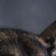

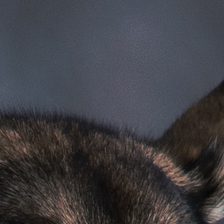

In [7]:
# Take a look of one training image
for x ,y in train_set.skip(850).take(1):
    img_small = Image.fromarray(x.numpy())
    img = Image.fromarray(y.numpy())
    img_small.show()
    img.show()

In [25]:
ds_train = train_set.map(normalize_img, AUTOTUNE).batch(64).prefetch(AUTOTUNE)
ds_val = val_set.map(normalize_img, AUTOTUNE).batch(64).prefetch(AUTOTUNE)

### Helper Functions

In [9]:
# helper function to avoid repeated code later
def plot_loss(model_history, out_file = None, train_col=None, val_col=None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    if train_col:
        ax[0].plot(history.history[train_col])
        ax[0].plot(history.history[val_col])
        ax[0].set_title('model psnr')
        ax[0].set_ylabel('psnr')
        ax[0].set_xlabel('epoch')
        ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    if out_file:
        plt.savefig(out_file)

In [10]:
# Helper functions to visulize reconstruction results
def compare_results(model, path=None, name='Deep Learning Model'):
    if not path or not os.path.isfile(path): return 
    img = Image.open(path)
    w, h = img.size
    img_low = img.resize((w // 4, h // 4))
    img_rec = (np.array(img_low) - MEAN) / 127.5
    img_rec = model.predict_step(np.expand_dims(img_rec, axis=0))
    img_low = img_low.resize((w,h))
    img_rec = img_rec.numpy()
    img_rec = img_rec[0]
    img_rec = np.clip(img_rec*127.5 + MEAN, 0,255).astype('uint8')
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12,4))
    ax0.imshow(img_low)
    ax1.imshow(img_rec)
    ax2.imshow(img)
    ax0.set_title('Bicubic')
    ax1.set_title(name)
    ax2.set_title('Original Image')
    
    
    

### Training Codes

#### Train SRCNN

In [11]:
srcnn = SRCNN()
compile_srcnn(srcnn)
srcnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 up_sampling2d (UpSampling2D  (None, None, None, 3)    0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_______________________________________________________

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_psnr', patience=3, mode='max', restore_best_weights=True)
epochs = 40
t1 = time.time()
srcnn_history = srcnn.fit(ds_train,epochs=epochs,validation_data=ds_val, callbacks=[es])
t2 = time.time()

In [ ]:
plot_loss(srcnn_history, train_col='psnr', val_col='val_psnr')
t = t2-t1
print(f"Time to train SRCNN {t // 60}min, {t% 60}s")

#### Train WDSR

In [137]:
wdsr = WDSR(blocks=5)
compile_wdsr(wdsr)
wdsr.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 weight_normalization_378 (Weig  (None, None, None,   289        ['input_18[0][0]']               
 htNormalization)               32)                                                               
                                                                                                  
 resblok_0 (ResBlock)           (None, None, None,   147938      ['weight_normalization_378[0][0]'
                                32)                              ]                         

In [138]:
es = keras.callbacks.EarlyStopping(monitor='val_psnr', mode='max', patience=3, min_delta=0.1, restore_best_weights=True)
epochs = 40
t1 = time.time()
wdsr_history = wdsr.fit(ds_train,epochs=epochs,validation_data=ds_val, callbacks=[es])
t2 = time.time()

Epoch 1/40
203/203 [==============================] - 65s 320ms/step - loss: 0.5598 - psnr: 8.1097 - val_loss: 0.3020 - val_psnr: 12.6286
Epoch 2/40
203/203 [==============================] - 65s 322ms/step - loss: 0.2472 - psnr: 14.7084 - val_loss: 0.2107 - val_psnr: 15.9377
Epoch 3/40
203/203 [==============================] - 66s 324ms/step - loss: 0.1766 - psnr: 17.8018 - val_loss: 0.1656 - val_psnr: 18.2194
Epoch 4/40
203/203 [==============================] - 66s 325ms/step - loss: 0.1413 - psnr: 19.8775 - val_loss: 0.1419 - val_psnr: 19.7668
Epoch 5/40
203/203 [==============================] - 66s 325ms/step - loss: 0.1224 - psnr: 21.2325 - val_loss: 0.1393 - val_psnr: 19.9755
Epoch 6/40
203/203 [==============================] - 66s 326ms/step - loss: 0.1100 - psnr: 22.1643 - val_loss: 0.1252 - val_psnr: 20.9831
Epoch 7/40
203/203 [==============================] - 66s 326ms/step - loss: 0.1026 - psnr: 22.7810 - val_loss: 0.1115 - val_psnr: 21.8933
Epoch 8/40
203/203 [========

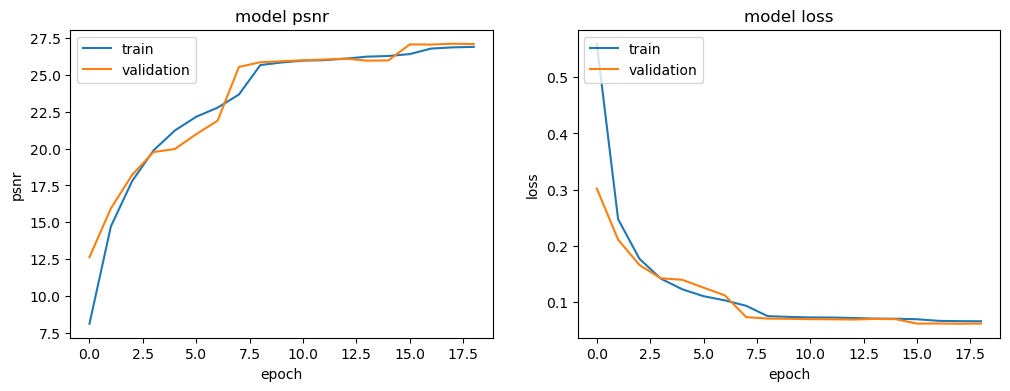

Time to train WDSR 21.0min, 11.282790899276733s


In [139]:
plot_loss(wdsr_history, train_col='psnr', val_col='val_psnr')
t = t2-t1
print(f"Time to train WDSR {t // 60}min, {t% 60}s")

### Demo

Try to look at the classical demo picture

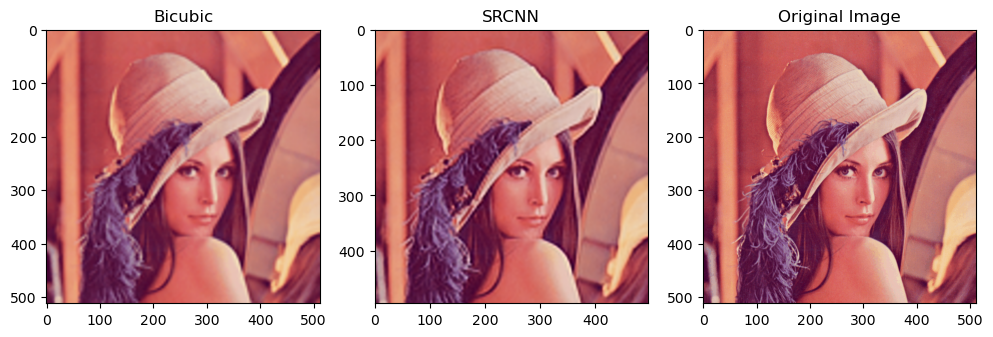

In [19]:
compare_results(srcnn, path=os.getcwd()+'/demo/lenna.bmp', name='SRCNN')

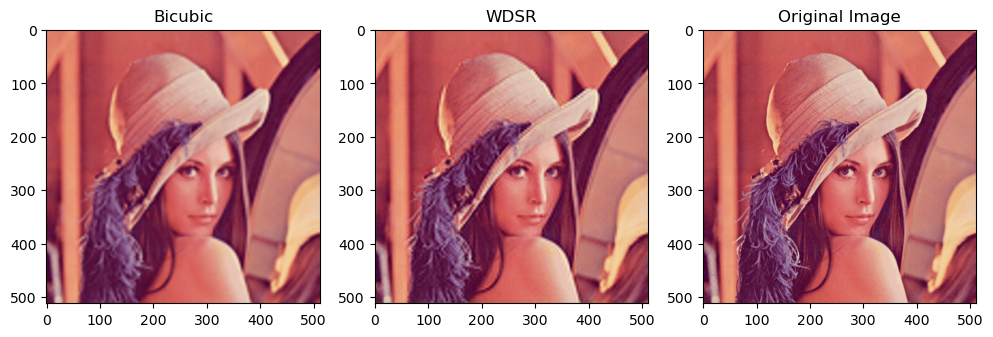

In [80]:
compare_results(wdsr, path=os.getcwd()+'/demo/lenna.bmp', name="WDSR")

In [140]:
wdsr.evaluate(ds_val)

36/36 [==============================] - 4s 102ms/step - loss: 0.0612 - psnr: 27.0784


[0.0612211637198925, 27.078441619873047]

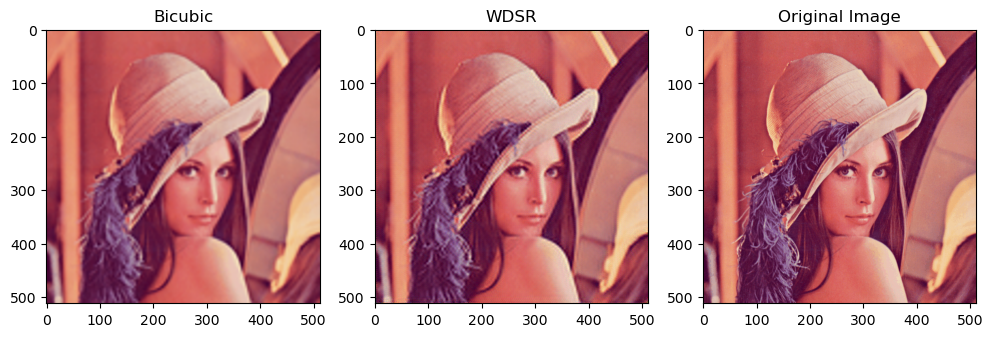

In [51]:
compare_results(wdsr, path=os.getcwd()+'/demo/lenna.bmp', name='WDSR')